# ABM Fake News - Modeling and Simulation Project

Group Members:

- Giorgio Bertone
- Song Bingliang
- Torres Antonio
- Klodian Dervishi

Supervisor: Daniele Giannandrea

### Import Libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random

## Task 1

Implement the basic model with a von Neumann neighbourhood and parameters N = 10000, c max =0.5, p + = 0.8. Come up with at least three global observables that characterize the population as a whole and that change in time, discuss their time evolution and visualize the dynamics of the system.

For this task we use the same code that we have created for task 2, but we set the number of trolls to zero. Doing so allows us to keep the notebook more clean and oredered.

In [ ]:
class Agent:
    def __init__(self, i, j, is_troll, belief, convincing_power):
        self.i = i  # Grid x-coordinate
        self.j = j  # Grid y-coordinate
        self.is_troll = is_troll  # Boolean indicating if the agent is a troll
        self.belief = belief  # Belief value between [-1, 1]
        self.convincing_power = convincing_power  # Influence strength [0, cmax]

def initialize_grid(N, cmax, p_plus, troll_frac):
    """Initializes a grid of agents with beliefs and convincing powers."""
    grid_size = int(np.sqrt(N))
    return [
        [
            Agent(
                i, j,
                is_troll := np.random.rand() < troll_frac,
                belief := -1.0 if is_troll else (
                    np.random.uniform(0, 1) if np.random.rand() < p_plus else np.random.uniform(-1, 0)
                ),
                convincing_power := np.random.uniform(0, cmax)
            )
            for j in range(grid_size)
        ]
        for i in range(grid_size)
    ]

def collect_statistics(grid):
    """Computes statistics for non-troll agents in the grid."""
    non_troll_agents = [agent for row in grid for agent in row if not agent.is_troll]
    non_troll_beliefs = np.array([agent.belief for agent in non_troll_agents])

    avg_belief = np.mean(non_troll_beliefs)
    var_belief = np.var(non_troll_beliefs)
    pos_frac = np.mean(non_troll_beliefs > 0)

    return avg_belief, var_belief, pos_frac

def update_beliefs(grid, N):
    """Selects 10% of non-troll agents and updates their beliefs based on neighbors' influence."""
    grid_size = len(grid)
    non_troll_agents = [agent for row in grid for agent in row if not agent.is_troll]
    selected_indices = np.random.choice(len(non_troll_agents), size=int(0.1 * N), replace=False)

    for idx in selected_indices:
        agent = non_troll_agents[idx]
        i, j = agent.i, agent.j
        # Von Neuman neighborhood
        neighbors = [
            grid[(i-1) % grid_size][j],  # North
            grid[(i+1) % grid_size][j],  # South
            grid[i][(j-1) % grid_size],  # West
            grid[i][(j+1) % grid_size]   # East
        ]

        influence = sum(nb.convincing_power * nb.belief for nb in neighbors)
        agent.belief += influence / len(neighbors)
        agent.belief = np.clip(agent.belief, -1, 1)  # Maintain bounds

def run_simulation(N, cmax, p_plus, troll_frac, timesteps):
    """Runs a single simulation and returns belief evolution over time."""
    grid = initialize_grid(N, cmax, p_plus, troll_frac)

    avg_beliefs, belief_variances, pos_belief_fractions = [], [], []
    for _ in range(timesteps):
        avg_belief, var_belief, pos_frac = collect_statistics(grid)
        avg_beliefs.append(avg_belief)
        belief_variances.append(var_belief)
        pos_belief_fractions.append(pos_frac)
        update_beliefs(grid, N)

    return np.array(avg_beliefs), np.array(belief_variances), np.array(pos_belief_fractions)

def compute_confidence_intervals(data, num_runs):
    """Computes mean and 95% confidence intervals."""
    mean = np.mean(data, axis=0)
    ci = 1.96 * np.std(data, axis=0) / np.sqrt(num_runs)
    return mean, ci

def plot_results(timesteps, avg_beliefs, belief_variances, pos_belief_fractions):
    """Plots the mean values with confidence intervals."""
    time = np.arange(timesteps)

    plt.figure(figsize=(12, 8))

    plt.subplot(3, 1, 1)
    plt.plot(time, avg_beliefs[0], label='Average Belief', color='blue')
    plt.fill_between(time, avg_beliefs[0] - avg_beliefs[1], avg_beliefs[0] + avg_beliefs[1], color='blue', alpha=0.3)
    plt.xlabel('Time')
    plt.ylabel('Average Belief')
    plt.legend()
    plt.title('Belief Evolution Over Time')
    plt.grid(True)

    plt.subplot(3, 1, 2)
    plt.plot(time, belief_variances[0], label='Belief Polarization', color='orange')
    plt.fill_between(time, belief_variances[0] - belief_variances[1], belief_variances[0] + belief_variances[1], color='orange', alpha=0.3)
    plt.xlabel('Time')
    plt.ylabel('Variance of Beliefs')
    plt.legend()
    plt.title('Belief Polarization Over Time')
    plt.grid(True)

    plt.subplot(3, 1, 3)
    plt.plot(time, pos_belief_fractions[0], label='Fraction Positive', color='green')
    plt.fill_between(time, pos_belief_fractions[0] - pos_belief_fractions[1], pos_belief_fractions[0] + pos_belief_fractions[1], color='green', alpha=0.3)
    plt.xlabel('Time')
    plt.ylabel('Fraction Positive')
    plt.legend()
    plt.title('Fraction of Positive Beliefs Over Time')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

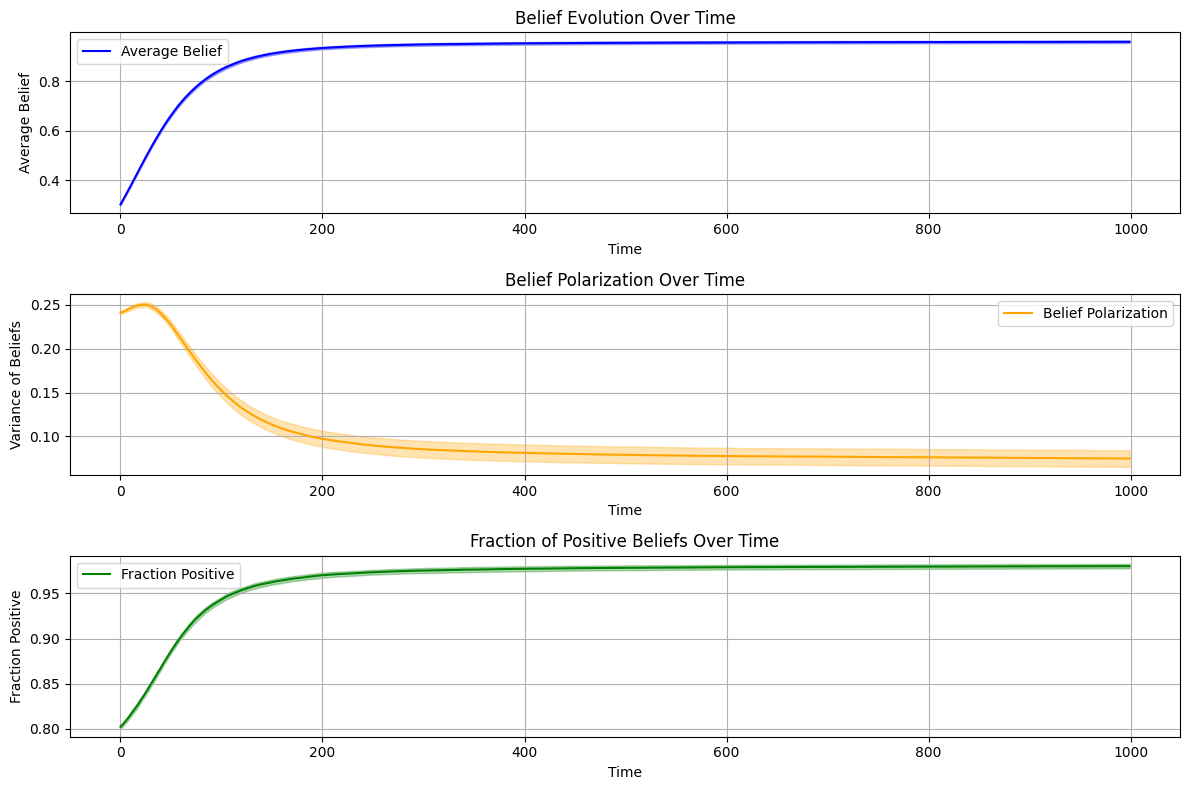


Final Average Belief: 0.9607 +- 0.0050
Final Belief Polarization: 0.0748 +- 0.0094
Final Fraction of Positive Beliefs: 0.9803 +- 0.0025


In [ ]:
# Simulation parameters
N = 10000
cmax = 0.5
p_plus = 0.8
troll_frac = 0
timesteps = 1000
num_runs = 10


# Run multiple simulations
all_avg_beliefs = np.zeros((num_runs, timesteps))
all_belief_variances = np.zeros((num_runs, timesteps))
all_pos_belief_fractions = np.zeros((num_runs, timesteps))

for run in range(num_runs):
    avg_beliefs, belief_variances, pos_belief_fractions = run_simulation(N, cmax, p_plus, troll_frac, timesteps)
    all_avg_beliefs[run, :] = avg_beliefs
    all_belief_variances[run, :] = belief_variances
    all_pos_belief_fractions[run, :] = pos_belief_fractions


# Compute mean and confidence intervals
avg_beliefs = compute_confidence_intervals(all_avg_beliefs, num_runs)
belief_variances = compute_confidence_intervals(all_belief_variances, num_runs)
pos_belief_fractions = compute_confidence_intervals(all_pos_belief_fractions, num_runs)

# Plot results
plot_results(timesteps, avg_beliefs, belief_variances, pos_belief_fractions)

print()
print(f"Final Average Belief: {avg_beliefs[0][-1]:.4f} +- {avg_beliefs[1][-1]:.4f}")
print(f"Final Belief Polarization: {belief_variances[0][-1]:.4f} +- {belief_variances[1][-1]:.4f}")
print(f"Final Fraction of Positive Beliefs: {pos_belief_fractions[0][-1]:.4f} +- {pos_belief_fractions[1][-1]:.4f}")

## Task 2

Introduce trolls into the model. They are characterized by their belief in the fake news b i = −1, which does not change. Find which fraction of the population needs to be trolls, such that more than half of the normal population (non-trolls) have a belief b i < 0 after 3000 timesteps.


For this Task, we first introduce the trolls and look at the simulation values with a random fraction (in our case 0.1).

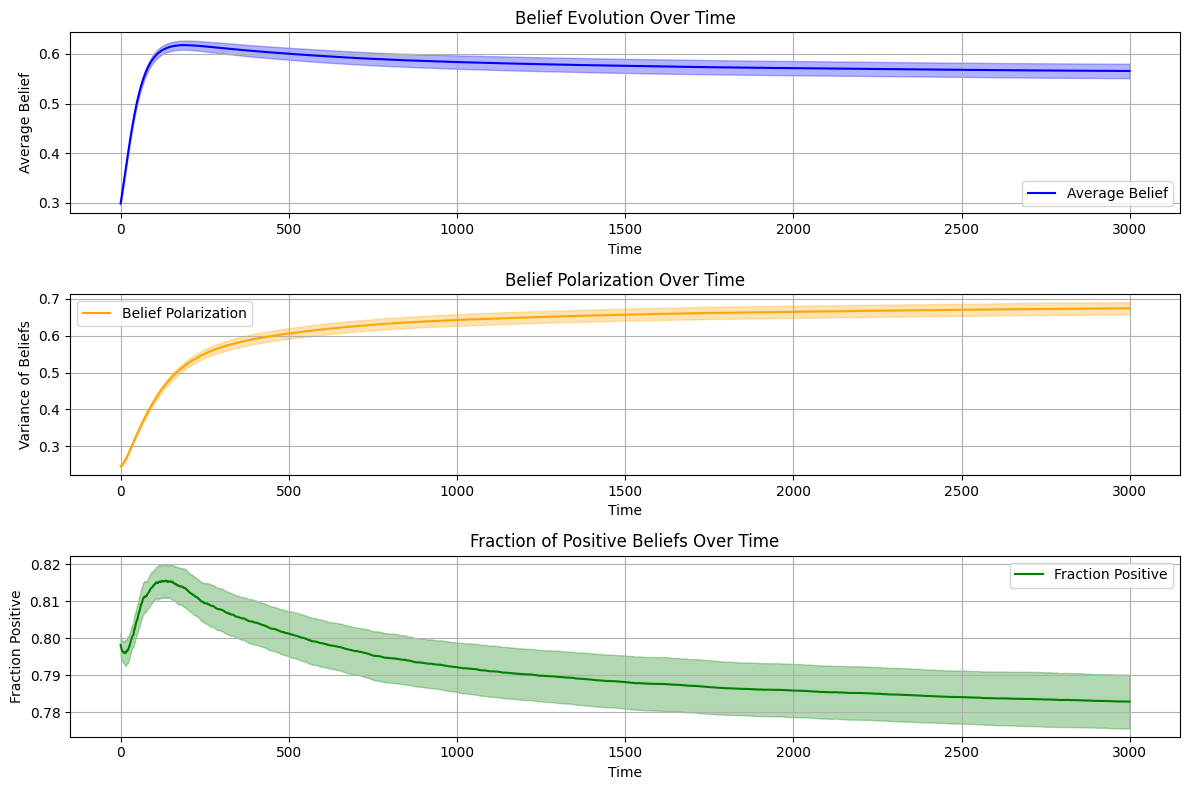


Final Average Belief: 0.5657 +- 0.0145
Final Belief Polarization: 0.6746 +- 0.0166
Final Fraction of Positive Beliefs: 0.7829 +- 0.0073


In [ ]:
# Simulation parameters
N = 10000
cmax = 0.5
p_plus = 0.8
troll_frac = 0.1
timesteps = 3000
num_runs = 10


# Run multiple simulations
all_avg_beliefs = np.zeros((num_runs, timesteps))
all_belief_variances = np.zeros((num_runs, timesteps))
all_pos_belief_fractions = np.zeros((num_runs, timesteps))

for run in range(num_runs):
    avg_beliefs, belief_variances, pos_belief_fractions = run_simulation(N, cmax, p_plus, troll_frac, timesteps)
    all_avg_beliefs[run, :] = avg_beliefs
    all_belief_variances[run, :] = belief_variances
    all_pos_belief_fractions[run, :] = pos_belief_fractions


# Compute mean and confidence intervals
avg_beliefs = compute_confidence_intervals(all_avg_beliefs, num_runs)
belief_variances = compute_confidence_intervals(all_belief_variances, num_runs)
pos_belief_fractions = compute_confidence_intervals(all_pos_belief_fractions, num_runs)

# Plot results
plot_results(timesteps, avg_beliefs, belief_variances, pos_belief_fractions)

print()
print(f"Final Average Belief: {avg_beliefs[0][-1]:.4f} +- {avg_beliefs[1][-1]:.4f}")
print(f"Final Belief Polarization: {belief_variances[0][-1]:.4f} +- {belief_variances[1][-1]:.4f}")
print(f"Final Fraction of Positive Beliefs: {pos_belief_fractions[0][-1]:.4f} +- {pos_belief_fractions[1][-1]:.4f}")

Next we use binary search to look for the troll fraction that gives a fraction of positive belief lower than 0.5. We require also the upper bound of the cofnidence interval to be lower than 0.5.

Troll fraction = 0.500, avg_pos = 0.042, CI = [0.037, 0.046]
Troll fraction = 0.250, avg_pos = 0.359, CI = [0.349, 0.369]
Troll fraction = 0.125, avg_pos = 0.728, CI = [0.721, 0.735]
Troll fraction = 0.188, avg_pos = 0.545, CI = [0.532, 0.558]
Troll fraction = 0.219, avg_pos = 0.448, CI = [0.436, 0.460]
Troll fraction = 0.203, avg_pos = 0.492, CI = [0.481, 0.504]
Troll fraction = 0.211, avg_pos = 0.471, CI = [0.465, 0.477]

Critical troll fraction found: 0.207


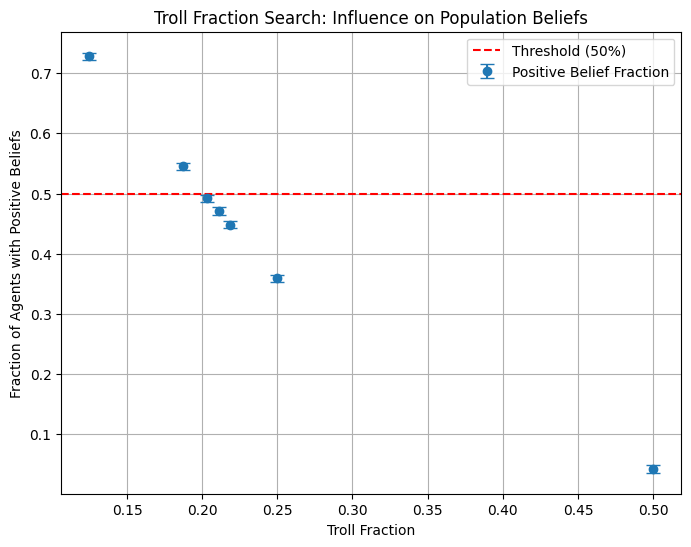

In [ ]:
# Store data for plotting
troll_fractions_tested = []
avg_pos_beliefs = []
upper_ci_pos_beliefs = []
lower_ci_pos_beliefs = []

# Binary search for critical troll fraction
troll_search = True
tol = 0.01
low = 0.0
high = 1.0

if troll_search:
    timesteps_threshold = 3000
    num_runs_threshold = 10        # Number of simulations per troll fraction

    while high - low > tol:
        mid = (low + high) / 2
        pos_fracs = np.zeros(num_runs_threshold)

        # Run multiple simulations for confidence interval estimation
        for run in range(num_runs_threshold):
            _, _, pos_belief_fractions = run_simulation(N, cmax, p_plus, mid, timesteps_threshold)
            pos_fracs[run] = pos_belief_fractions[-1]  # Final fraction of positive beliefs

        # Compute mean and confidence interval
        avg_pos, ci_pos = compute_confidence_intervals(pos_fracs, num_runs_threshold)
        upper_ci_pos = avg_pos + ci_pos
        lower_ci_pos = avg_pos - ci_pos

        # Store for plotting
        troll_fractions_tested.append(mid)
        avg_pos_beliefs.append(avg_pos)
        upper_ci_pos_beliefs.append(upper_ci_pos)
        lower_ci_pos_beliefs.append(lower_ci_pos)

        print(f"Troll fraction = {mid:.3f}, avg_pos = {avg_pos:.3f}, CI = [{lower_ci_pos:.3f}, {upper_ci_pos:.3f}]")

        # Binary search decision
        if avg_pos + ci_pos < 0.5:  # Ensure upper CI is below 0.5
            high = mid
        else:
            low = mid

    # Final estimated troll fraction
    troll_frac = (low + high) / 2
    print(f"\nCritical troll fraction found: {troll_frac:.3f}")

# Plot troll fraction search results
plt.figure(figsize=(8, 6))
plt.errorbar(troll_fractions_tested, avg_pos_beliefs, yerr=ci_pos, fmt='o', capsize=5, label='Positive Belief Fraction')
plt.axhline(0.5, color='red', linestyle='--', label='Threshold (50%)')

plt.xlabel('Troll Fraction')
plt.ylabel('Fraction of Agents with Positive Beliefs')
plt.title('Troll Fraction Search: Influence on Population Beliefs')
plt.legend()
plt.grid(True)
plt.show()

Now we can run the simulation with the new found fraction and look at the results.

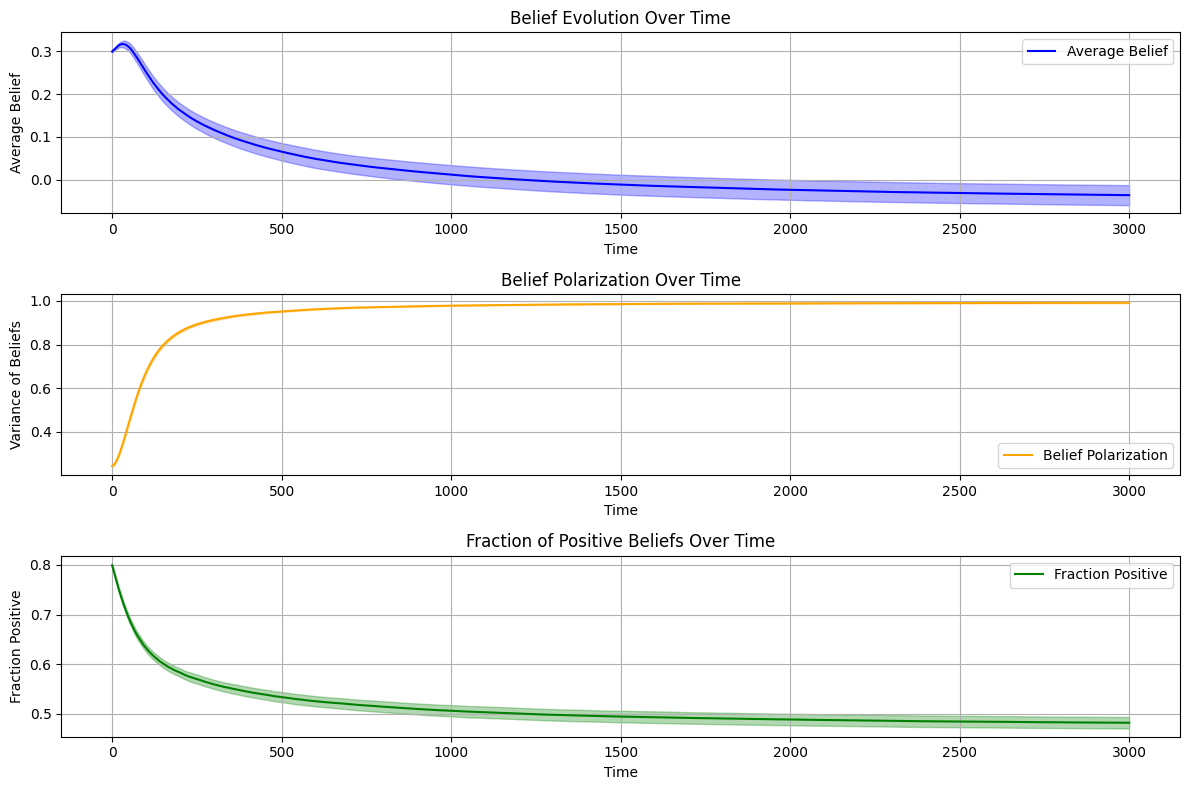


Final Average Belief: -0.0360 +- 0.0234
Final Belief Polarization: 0.9916 +- 0.0022
Final Fraction of Positive Beliefs: 0.4822 +- 0.0116


In [ ]:
# Simulation parameters
N = 10000
cmax = 0.5
p_plus = 0.8
troll_frac = 0.207
timesteps = 3000
num_runs = 10


# Run multiple simulations
all_avg_beliefs = np.zeros((num_runs, timesteps))
all_belief_variances = np.zeros((num_runs, timesteps))
all_pos_belief_fractions = np.zeros((num_runs, timesteps))

for run in range(num_runs):
    avg_beliefs, belief_variances, pos_belief_fractions = run_simulation(N, cmax, p_plus, troll_frac, timesteps)
    all_avg_beliefs[run, :] = avg_beliefs
    all_belief_variances[run, :] = belief_variances
    all_pos_belief_fractions[run, :] = pos_belief_fractions


# Compute mean and confidence intervals
avg_beliefs = compute_confidence_intervals(all_avg_beliefs, num_runs)
belief_variances = compute_confidence_intervals(all_belief_variances, num_runs)
pos_belief_fractions = compute_confidence_intervals(all_pos_belief_fractions, num_runs)

# Plot results
plot_results(timesteps, avg_beliefs, belief_variances, pos_belief_fractions)

print()
print(f"Final Average Belief: {avg_beliefs[0][-1]:.4f} +- {avg_beliefs[1][-1]:.4f}")
print(f"Final Belief Polarization: {belief_variances[0][-1]:.4f} +- {belief_variances[1][-1]:.4f}")
print(f"Final Fraction of Positive Beliefs: {pos_belief_fractions[0][-1]:.4f} +- {pos_belief_fractions[1][-1]:.4f}")

Indeed, the final fraction of positive belief is below 0.5

## Task 4

Come up with a mechanism to counter the trolls in this model and implement it.


### Trusted agents

The first mechanism we come up with is the introduction of trusted agents. Trusted agents:​ fixed belief = 1 ,higher convincing power​.


Interpretation: trusted news sources or verified profiles​.


For this task we  have to modify some of the previous functions to account for the new agent types and characteristics

In [ ]:
class Agent:
    def __init__(self, i, j, is_troll, belief, convincing_power, is_trusted):
        self.i = i  # Grid x-coordinate
        self.j = j  # Grid y-coordinate
        self.is_troll = is_troll  # Boolean indicating if the agent is a troll
        self.belief = belief  # Belief value between [-1, 1]
        self.convincing_power = convincing_power  # Influence strength [0, cmax]
        self.is_trusted = is_trusted  # Boolean indicating if the agent is trusted

def initialize_grid(N, cmax, p_plus, troll_frac, trusted_frac):
    """Initializes a grid of agents with beliefs and convincing powers."""
    grid_size = int(np.sqrt(N))
    grid = []
    for i in range(grid_size):
        row = []
        for j in range(grid_size):
            is_troll = np.random.rand() < troll_frac
            is_trusted = np.random.rand() < trusted_frac
            if is_troll:
                belief = -1.0
            else:
                if is_trusted:
                    belief = 1.0
                else:
                    belief = np.random.uniform(0, 1) if np.random.rand() < p_plus else np.random.uniform(-1, 0)
            convincing_power = (
                np.random.uniform(0, cmax) + np.random.uniform(0, cmax/2)
                if is_trusted
                else np.random.uniform(0, cmax)
            )
            row.append(Agent(i, j, is_troll, belief, convincing_power, is_trusted))
        grid.append(row)
    return grid

def collect_statistics(grid):
    """Collects statistics for non-troll agents in the grid."""
    non_troll_agents = [agent for row in grid for agent in row if (not agent.is_troll and not agent.is_trusted)]
    non_troll_beliefs = np.array([agent.belief for agent in non_troll_agents])

    avg_belief = np.mean(non_troll_beliefs)
    var_belief = np.var(non_troll_beliefs)
    pos_frac = np.mean(non_troll_beliefs > 0)

    return avg_belief, var_belief, pos_frac

def update_beliefs(grid, N):
    """Updates beliefs of a random subset of non-troll agents."""
    grid_size = len(grid)
    non_troll_agents = [agent for row in grid for agent in row if (not agent.is_troll and not agent.is_trusted)]
    selected_indices = np.random.choice(len(non_troll_agents), size=int(0.1 * N), replace=False)

    for idx in selected_indices:
        agent = non_troll_agents[idx]
        i, j = agent.i, agent.j
        neighbors = [
            grid[(i-1) % grid_size][j],  # North
            grid[(i+1) % grid_size][j],  # South
            grid[i][(j-1) % grid_size],  # West
            grid[i][(j+1) % grid_size]   # East
        ]

        influence = sum(nb.convincing_power * nb.belief for nb in neighbors)
        agent.belief += influence / len(neighbors)
        agent.belief = np.clip(agent.belief, -1, 1)  # Maintain bounds

def run_simulation(N, cmax, p_plus, troll_frac, trusted_frac, timesteps):
    """Runs a single simulation for the given parameters."""
    grid = initialize_grid(N, cmax, p_plus, troll_frac, trusted_frac)

    avg_beliefs, belief_variances, pos_belief_fractions = [], [], []

    for t in range(timesteps):
        avg_belief, var_belief, pos_frac = collect_statistics(grid)
        avg_beliefs.append(avg_belief)
        belief_variances.append(var_belief)
        pos_belief_fractions.append(pos_frac)

        update_beliefs(grid, N)

    return np.array(avg_beliefs), np.array(belief_variances), np.array(pos_belief_fractions)

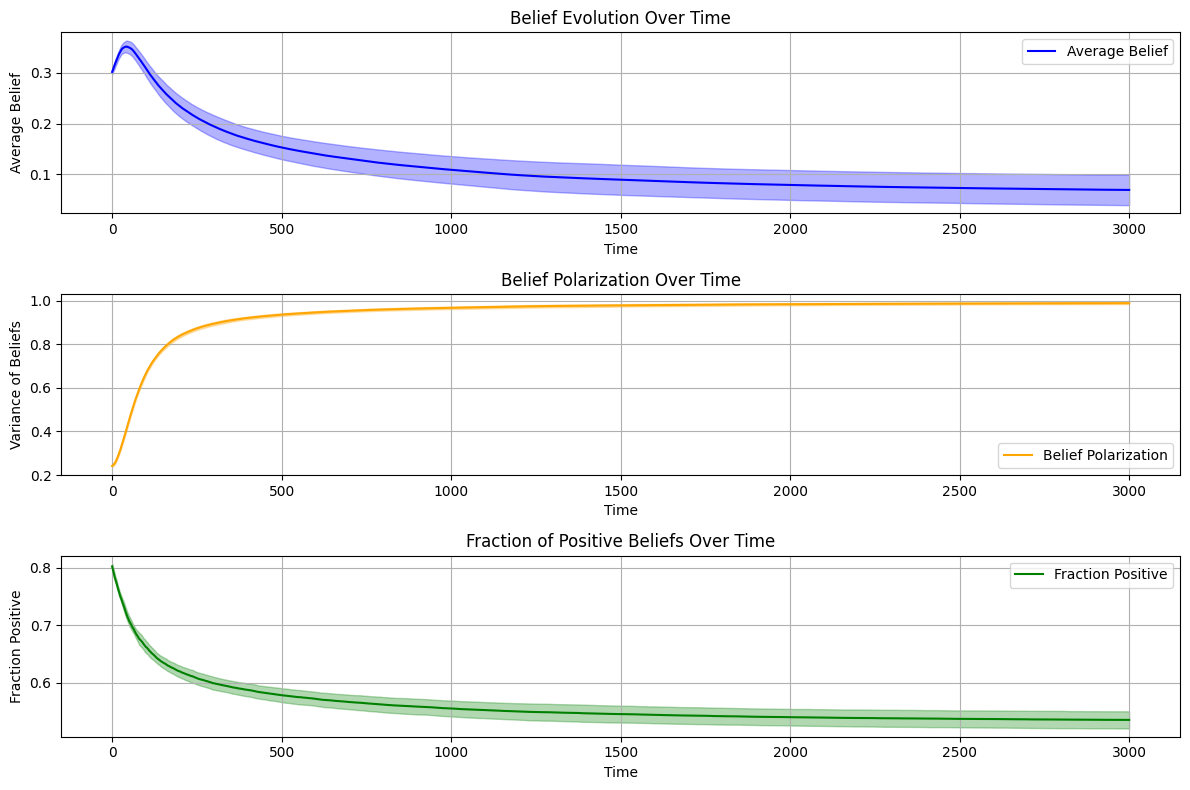

Final Average Belief: 0.0689 +- 0.0301
Final Belief Polarization: 0.9888 +- 0.0042
Final Fraction of Positive Beliefs: 0.5349 +- 0.0150


In [ ]:
# Parameters for simulation
N = 10000  # Population size
cmax = 0.5  # Maximum convincing power
p_plus = 0.8  # Fraction of initial positive beliefs

troll_frac = 0.207 # Fraction of trolls
trusted_frac = 0.05  # Fraction of trusted agents

timesteps = 3000  # Number of timesteps
num_runs = 5  # Number of repetitions

# Run multiple simulations
all_avg_beliefs = np.zeros((num_runs, timesteps))
all_belief_variances = np.zeros((num_runs, timesteps))
all_pos_belief_fractions = np.zeros((num_runs, timesteps))

for run in range(num_runs):
    avg_beliefs, belief_variances, pos_belief_fractions = run_simulation(N, cmax, p_plus, troll_frac, trusted_frac, timesteps)
    all_avg_beliefs[run, :] = avg_beliefs
    all_belief_variances[run, :] = belief_variances
    all_pos_belief_fractions[run, :] = pos_belief_fractions

# Compute mean and confidence intervals
avg_beliefs = compute_confidence_intervals(all_avg_beliefs, num_runs)
belief_variances = compute_confidence_intervals(all_belief_variances, num_runs)
pos_belief_fractions = compute_confidence_intervals(all_pos_belief_fractions, num_runs)

# Plot the results
plot_results(timesteps, avg_beliefs, belief_variances, pos_belief_fractions)

print(f"Final Average Belief: {avg_beliefs[0][-1]:.4f} +- {avg_beliefs[1][-1]:.4f}")
print(f"Final Belief Polarization: {belief_variances[0][-1]:.4f} +- {belief_variances[1][-1]:.4f}")
print(f"Final Fraction of Positive Beliefs: {pos_belief_fractions[0][-1]:.4f} +- {pos_belief_fractions[1][-1]:.4f}")

We notice that a fraction of trusted agents of 0.05 already helps in countering trolls. Now we try reducing trusted agents to see minimum fraction that still makes them effective. We try with 0.01.

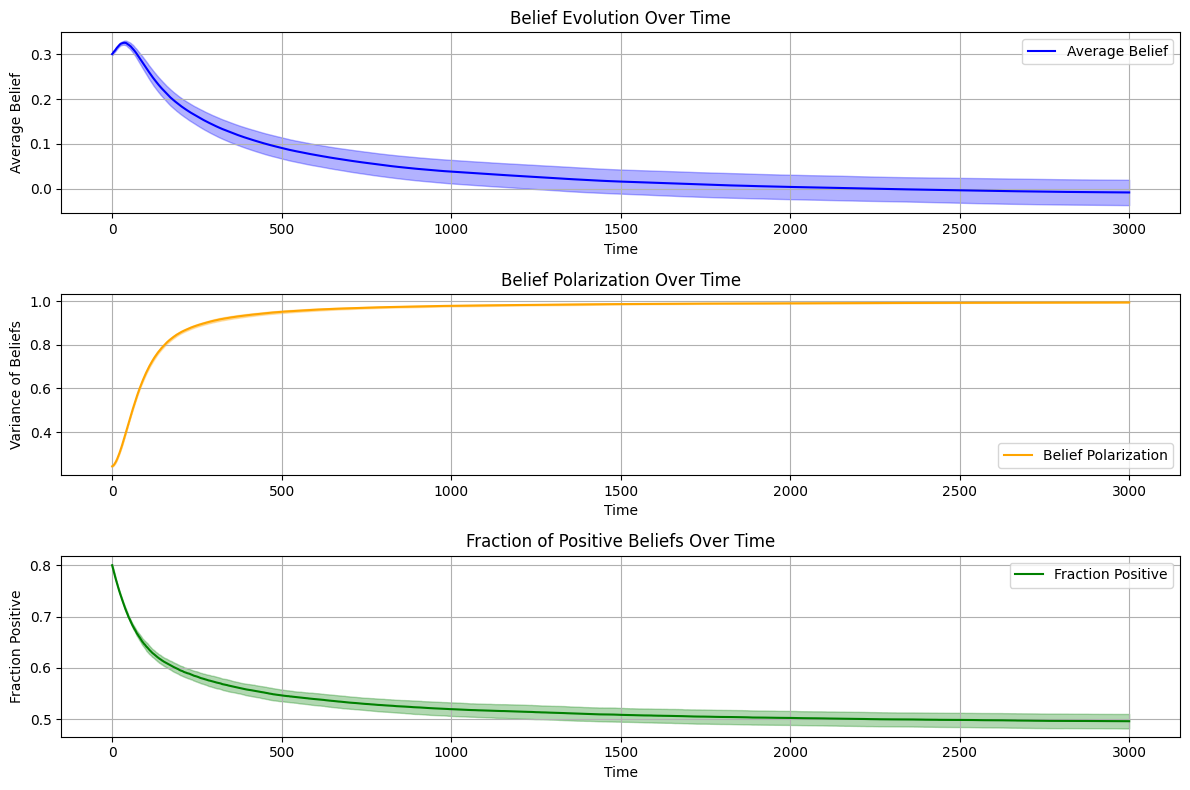

Final Average Belief: -0.0079 +- 0.0283
Final Belief Polarization: 0.9939 +- 0.0008
Final Fraction of Positive Beliefs: 0.4963 +- 0.0141


In [ ]:
# Parameters for simulation
N = 10000  # Population size
cmax = 0.5  # Maximum convincing power
p_plus = 0.8  # Fraction of initial positive beliefs

troll_frac = 0.207 # Fraction of trolls
trusted_frac = 0.01  # Fraction of trusted agents

timesteps = 3000  # Number of timesteps
num_runs = 5  # Number of repetitions

# Run multiple simulations
all_avg_beliefs = np.zeros((num_runs, timesteps))
all_belief_variances = np.zeros((num_runs, timesteps))
all_pos_belief_fractions = np.zeros((num_runs, timesteps))

for run in range(num_runs):
    avg_beliefs, belief_variances, pos_belief_fractions = run_simulation(N, cmax, p_plus, troll_frac, trusted_frac, timesteps)
    all_avg_beliefs[run, :] = avg_beliefs
    all_belief_variances[run, :] = belief_variances
    all_pos_belief_fractions[run, :] = pos_belief_fractions

# Compute mean and confidence intervals
avg_beliefs = compute_confidence_intervals(all_avg_beliefs, num_runs)
belief_variances = compute_confidence_intervals(all_belief_variances, num_runs)
pos_belief_fractions = compute_confidence_intervals(all_pos_belief_fractions, num_runs)

# Plot the results
plot_results(timesteps, avg_beliefs, belief_variances, pos_belief_fractions)

print(f"Final Average Belief: {avg_beliefs[0][-1]:.4f} +- {avg_beliefs[1][-1]:.4f}")
print(f"Final Belief Polarization: {belief_variances[0][-1]:.4f} +- {belief_variances[1][-1]:.4f}")
print(f"Final Fraction of Positive Beliefs: {pos_belief_fractions[0][-1]:.4f} +- {pos_belief_fractions[1][-1]:.4f}")

This fraction seems too low and not effective

### Reports and shadowbanning

The next mechanism consists of giving agents the possibility to report suspicious activity​.

With a certain probability, some agents called interactors detect a troll and report it. The number of agents that can detect a troll is given by tha active fraction. We start with 0.05, that seems a reasonable value for the number of people that  actively report content or accounts. Moreover we establish that if a troll and an interactor come into contatct, the interactor will report the troll with probability of 70%.

Shadowban agents that received a certain number of reports by reducing their convincing power​.

In [ ]:
class Agent:
    def __init__(self, i, j, is_troll, belief, convincing_power, is_trusted):
        self.i = i  # Grid x-coordinate
        self.j = j  # Grid y-coordinate
        self.is_troll = is_troll  # Boolean indicating if the agent is a troll
        self.belief = belief  # Belief value between [-1, 1]
        self.convincing_power = convincing_power  # Influence strength [0, cmax]
        self.is_trusted = is_trusted  # Boolean indicating if the agent is trusted
        self.reports = 0  # Number of reports received
        self.shadowbanned = False  # Shadowban status

    @property
    def effective_convincing_power(self):
        """Return the convincing power, halved if the agent is shadowbanned."""
        return self.convincing_power / 2 if self.shadowbanned else self.convincing_power

def update_beliefs(grid, N):
    """Updates beliefs of a random subset of non-troll agents."""
    grid_size = len(grid)
    non_troll_agents = [agent for row in grid for agent in row if (not agent.is_troll and not agent.is_trusted)]
    selected_indices = np.random.choice(len(non_troll_agents), size=int(0.1 * N), replace=False)

    for idx in selected_indices:
        agent = non_troll_agents[idx]
        i, j = agent.i, agent.j
        neighbors = [
            grid[(i-1) % grid_size][j],  # North
            grid[(i+1) % grid_size][j],  # South
            grid[i][(j-1) % grid_size],  # West
            grid[i][(j+1) % grid_size]   # East
        ]

        influence = sum(nb.effective_convincing_power * nb.belief for nb in neighbors)
        agent.belief += influence / len(neighbors)
        agent.belief = np.clip(agent.belief, -1, 1)  # Maintain bounds

    # Simulate user-driven protections
    interactors = random.sample(
        [agent for row in grid for agent in row if not agent.shadowbanned],
        k=int(active_fraction * N)
    )

    for i in range(0, len(interactors), 2):
        if i + 1 >= len(interactors):
            break
        a1, a2 = interactors[i], interactors[i + 1]

        # Simulate content flagging
        if a1.is_troll and not a2.is_troll:
            if random.random() < 0.7:
                a1.reports += 1
        elif a2.is_troll and not a1.is_troll:
            if random.random() < 0.7:
                a2.reports += 1

    # Apply shadowban based on report threshold
    for row in grid:
        for agent in row:
            if agent.reports >= report_threshold:
                agent.shadowbanned = True

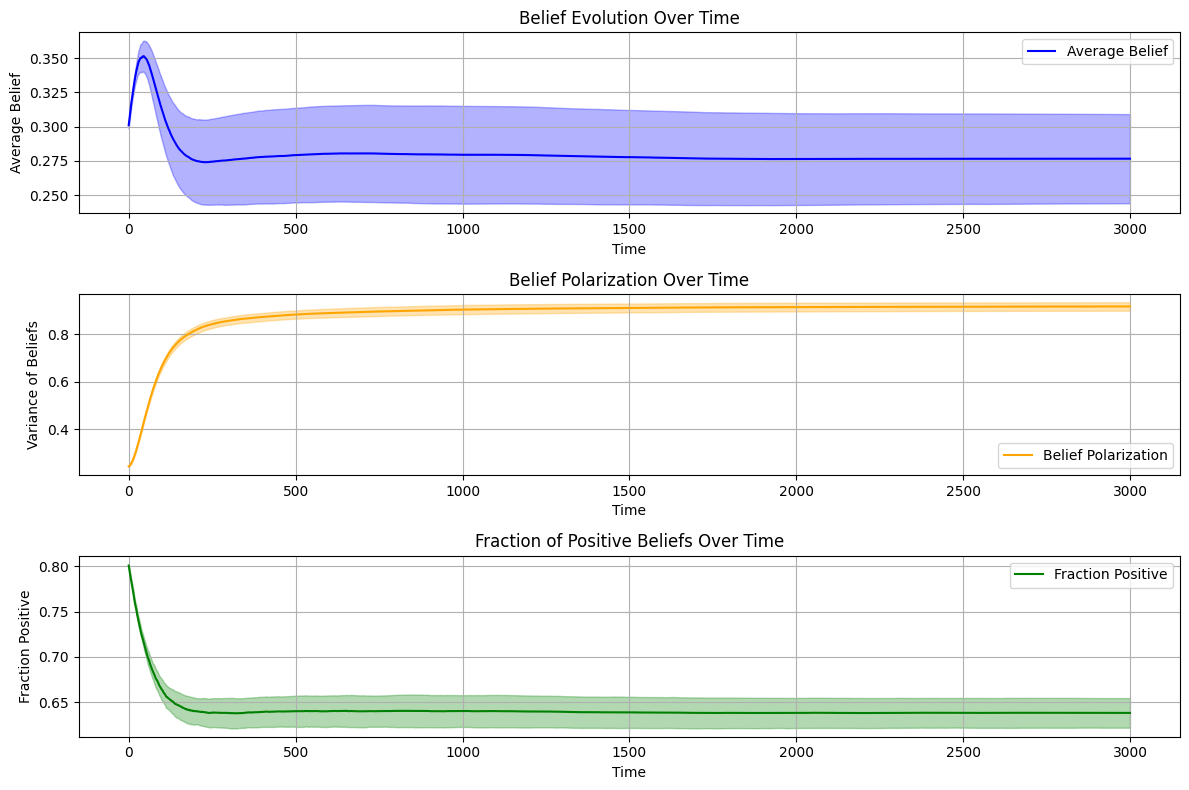

Final Average Belief: 0.2767 +- 0.0325
Final Belief Polarization: 0.9169 +- 0.0178
Final Fraction of Positive Beliefs: 0.6380 +- 0.0164


In [ ]:
# Parameters for simulation
N = 10000  # Population size
cmax = 0.5  # Maximum convincing power
p_plus = 0.8  # Fraction of initial positive beliefs

troll_frac = 0.207 # Fraction of trolls
trusted_frac = 0.05  # Fraction of trusted agents
active_fraction = 0.05  # Fraction of active agents that report
report_threshold = 5  # Reports required to shadowban a user

timesteps = 3000  # Number of timesteps
num_runs = 5  # Number of repetitions

# Run multiple simulations
all_avg_beliefs = np.zeros((num_runs, timesteps))
all_belief_variances = np.zeros((num_runs, timesteps))
all_pos_belief_fractions = np.zeros((num_runs, timesteps))

for run in range(num_runs):
    avg_beliefs, belief_variances, pos_belief_fractions = run_simulation(N, cmax, p_plus, troll_frac, trusted_frac, timesteps)
    all_avg_beliefs[run, :] = avg_beliefs
    all_belief_variances[run, :] = belief_variances
    all_pos_belief_fractions[run, :] = pos_belief_fractions

# Compute mean and confidence intervals
avg_beliefs = compute_confidence_intervals(all_avg_beliefs, num_runs)
belief_variances = compute_confidence_intervals(all_belief_variances, num_runs)
pos_belief_fractions = compute_confidence_intervals(all_pos_belief_fractions, num_runs)

# Plot the results
plot_results(timesteps, avg_beliefs, belief_variances, pos_belief_fractions)

print(f"Final Average Belief: {avg_beliefs[0][-1]:.4f} +- {avg_beliefs[1][-1]:.4f}")
print(f"Final Belief Polarization: {belief_variances[0][-1]:.4f} +- {belief_variances[1][-1]:.4f}")
print(f"Final Fraction of Positive Beliefs: {pos_belief_fractions[0][-1]:.4f} +- {pos_belief_fractions[1][-1]:.4f}")

### Community notes

Finally, we add community notes which are determined by majority voting of neighbors​.

If an agent believes fake news but most neighbors disagree, the agent’s belief shifts towards positive news​ by a small fraction (0.1).

In [ ]:
def update_beliefs(grid, N):
    """Updates beliefs of a random subset of non-troll agents."""
    grid_size = len(grid)
    non_troll_agents = [agent for row in grid for agent in row if (not agent.is_troll and not agent.is_trusted)]
    selected_indices = np.random.choice(len(non_troll_agents), size=int(0.1 * N), replace=False)

    for idx in selected_indices:
        agent = non_troll_agents[idx]
        i, j = agent.i, agent.j
        neighbors = [
            grid[(i-1) % grid_size][j],  # North
            grid[(i+1) % grid_size][j],  # South
            grid[i][(j-1) % grid_size],  # West
            grid[i][(j+1) % grid_size]   # East
        ]
        if agent.belief < 0:

            # Track the number of disagreements with neighbors
            disagreements = sum(
                1 for nb in neighbors if not nb.is_troll and np.sign(nb.belief) != np.sign(agent.belief)
            )

            # Apply community notes effect if disagreements exceed threshold
            if disagreements > community_note_threshold:
                agent.belief += 0.1  # Increase belief in true news

        influence = sum(nb.effective_convincing_power * nb.belief for nb in neighbors)
        agent.belief += influence / len(neighbors)
        agent.belief = np.clip(agent.belief, -1, 1)  # Maintain bounds

    # Simulate user-driven protections
    interactors = random.sample(
        [agent for row in grid for agent in row if not agent.shadowbanned],
        k=int(active_fraction * N)
    )

    for i in range(0, len(interactors), 2):
        if i + 1 >= len(interactors):
            break
        a1, a2 = interactors[i], interactors[i + 1]

        # Simulate content flagging
        if a1.is_troll and not a2.is_troll:
            if random.random() < 0.7:
                a1.reports += 1
        elif a2.is_troll and not a1.is_troll:
            if random.random() < 0.7:
                a2.reports += 1

    # Apply shadowban based on report threshold
    for row in grid:
        for agent in row:
            if agent.reports >= report_threshold:
                agent.shadowbanned = True


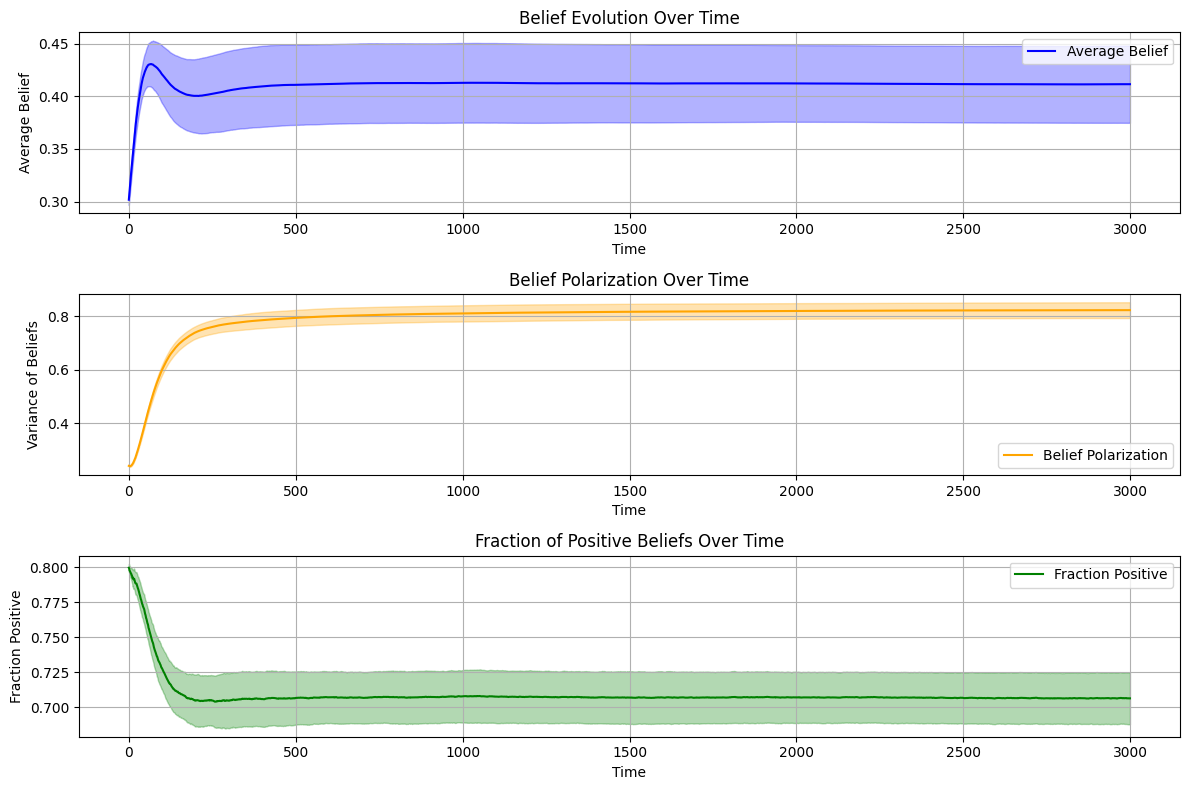

Final Average Belief: 0.4115 +- 0.0367
Final Belief Polarization: 0.8226 +- 0.0295
Final Fraction of Positive Beliefs: 0.7063 +- 0.0187


In [ ]:
# Parameters for simulation
N = 10000  # Population size
cmax = 0.5  # Maximum convincing power
p_plus = 0.8  # Fraction of initial positive beliefs

troll_frac = 0.207 # Fraction of trolls
trusted_frac = 0.05  # Fraction of trusted agents
active_fraction = 0.05  # Fraction of active agents that report
community_note_threshold = 2 # Number of disagremments required
report_threshold = 5  # Reports required to shadowban a user

timesteps = 3000  # Number of timesteps
num_runs = 5  # Number of repetitions

# Run multiple simulations
all_avg_beliefs = np.zeros((num_runs, timesteps))
all_belief_variances = np.zeros((num_runs, timesteps))
all_pos_belief_fractions = np.zeros((num_runs, timesteps))

for run in range(num_runs):
    avg_beliefs, belief_variances, pos_belief_fractions = run_simulation(N, cmax, p_plus, troll_frac, trusted_frac, timesteps)
    all_avg_beliefs[run, :] = avg_beliefs
    all_belief_variances[run, :] = belief_variances
    all_pos_belief_fractions[run, :] = pos_belief_fractions

# Compute mean and confidence intervals
avg_beliefs = compute_confidence_intervals(all_avg_beliefs, num_runs)
belief_variances = compute_confidence_intervals(all_belief_variances, num_runs)
pos_belief_fractions = compute_confidence_intervals(all_pos_belief_fractions, num_runs)

# Plot the results
plot_results(timesteps, avg_beliefs, belief_variances, pos_belief_fractions)

print(f"Final Average Belief: {avg_beliefs[0][-1]:.4f} +- {avg_beliefs[1][-1]:.4f}")
print(f"Final Belief Polarization: {belief_variances[0][-1]:.4f} +- {belief_variances[1][-1]:.4f}")
print(f"Final Fraction of Positive Beliefs: {pos_belief_fractions[0][-1]:.4f} +- {pos_belief_fractions[1][-1]:.4f}")

Community notes v2

We also add the fact that when community note is introduced, decrease also convincing power​ of the agent that got the community note. This is equivalent to reducing the visibility of the post or simulating the fact that users might recognize that account or post as unreliable.

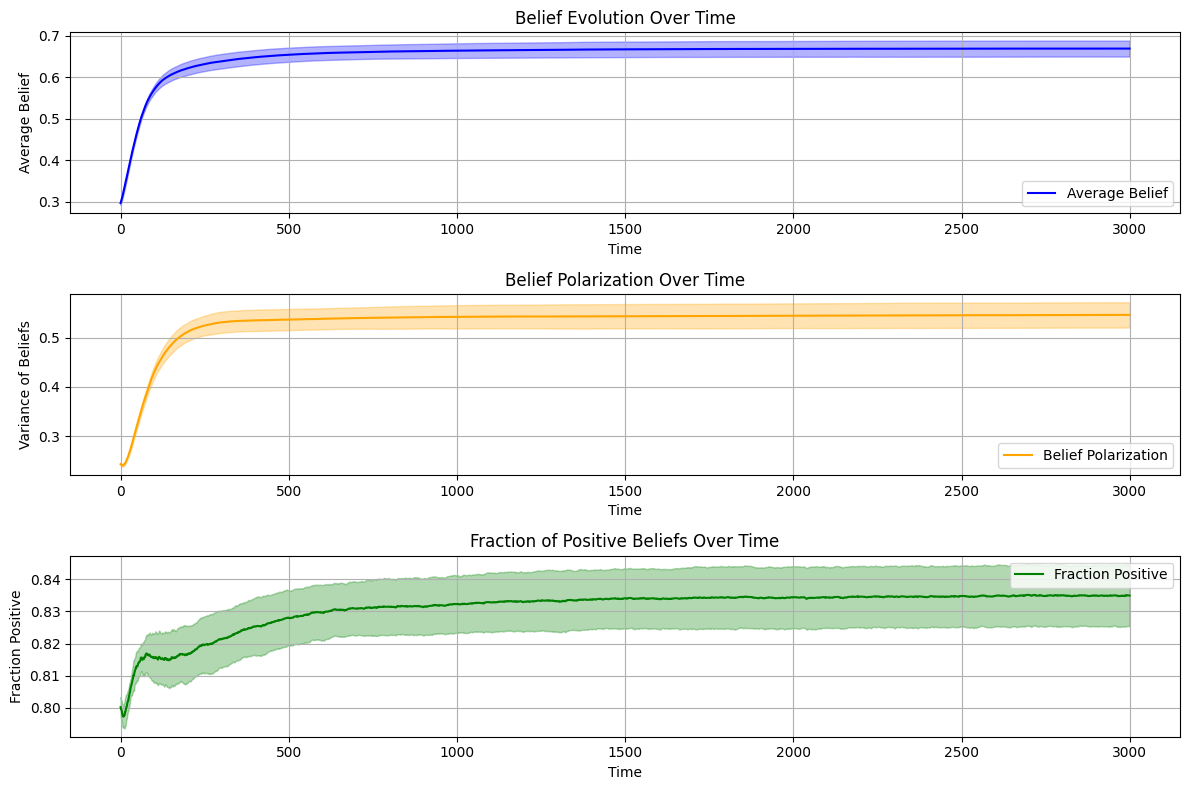

Final Average Belief: 0.6691 +- 0.0193
Final Belief Polarization: 0.5461 +- 0.0257
Final Fraction of Positive Beliefs: 0.8349 +- 0.0096


In [ ]:
def update_beliefs(grid, N):
    """Updates beliefs of a random subset of non-troll agents."""
    grid_size = len(grid)
    # Flatten grid
    all_agents = [
        agent for row in grid for agent in row
    ]

    # Select 10% of all agents for potential update
    selected_indices = np.random.choice(len(all_agents), size=int(0.1 * N), replace=False)

    # Update beliefs of selected agents
    for idx in selected_indices:
        agent = all_agents[idx]
        # Get neighbor coordinates with periodic boundaries
        i, j = agent.i, agent.j
        neighbors = [
            grid[(i-1) % grid_size][j],  # North
            grid[(i+1) % grid_size][j],  # South
            grid[i][(j-1) % grid_size],  # West
            grid[i][(j+1) % grid_size]   # East
        ]
        if agent.belief < 0:
            # Track the number of disagreements with neighbors
            disagreements = sum(
                1 for nb in neighbors if not nb.is_troll and np.sign(nb.belief) != np.sign(agent.belief)
            )

            # Apply community notes effect:
            if disagreements > community_note_threshold:
                # For non-troll agents with belief < 0, increase belief
                if not agent.is_troll:
                    agent.belief += 0.1  # Increase belief, clip to [-1, 1] later
                    agent.belief = np.clip(agent.belief, -1, 1)  # Ensure belief remains within bounds

                # For troll agents, decrease convincing power (also trusted agents can lose convincing power)
                else:
                    agent.convincing_power *= 0.7  # Reduce convincing power by 30%

        # For non-troll and non trusted agents, calculate social influence and update belief
        if not agent.is_troll and not agent.is_trusted:
            influence = sum(nb.effective_convincing_power * nb.belief for nb in neighbors)
            agent.belief += influence / len(neighbors)
            agent.belief = np.clip(agent.belief, -1, 1)  # Maintain bounds

    # Simulate user-driven protections
    interactors = random.sample(
        [agent for row in grid for agent in row if not agent.shadowbanned],
        k=int(active_fraction * N)
    )

    for i in range(0, len(interactors), 2):
        if i + 1 >= len(interactors):
            break
        a1, a2 = interactors[i], interactors[i + 1]

        # Simulate content flagging
        if a1.is_troll and not a2.is_troll:
            if random.random() < 0.7:
                a1.reports += 1
        elif a2.is_troll and not a1.is_troll:
            if random.random() < 0.7:
                a2.reports += 1

    # Apply shadowban based on report threshold
    for row in grid:
        for agent in row:
            if agent.reports >= report_threshold:
                agent.shadowbanned = True



# Parameters for simulation
N = 10000  # Population size
cmax = 0.5  # Maximum convincing power
p_plus = 0.8  # Fraction of initial positive beliefs

troll_frac = 0.207 # Fraction of trolls
trusted_frac = 0.05  # Fraction of trusted agents
community_note_threshold = 2
report_threshold = 5  # Reports required to shadowban a user
active_fraction = 0.05  # Fraction of active agents that report

timesteps = 3000  # Number of timesteps
num_runs = 5  # Number of repetitions

# Run multiple simulations
all_avg_beliefs = np.zeros((num_runs, timesteps))
all_belief_variances = np.zeros((num_runs, timesteps))
all_pos_belief_fractions = np.zeros((num_runs, timesteps))

for run in range(num_runs):
    avg_beliefs, belief_variances, pos_belief_fractions = run_simulation(N, cmax, p_plus, troll_frac, trusted_frac, timesteps)
    all_avg_beliefs[run, :] = avg_beliefs
    all_belief_variances[run, :] = belief_variances
    all_pos_belief_fractions[run, :] = pos_belief_fractions

# Compute mean and confidence intervals
avg_beliefs = compute_confidence_intervals(all_avg_beliefs, num_runs)
belief_variances = compute_confidence_intervals(all_belief_variances, num_runs)
pos_belief_fractions = compute_confidence_intervals(all_pos_belief_fractions, num_runs)

# Plot the results
plot_results(timesteps, avg_beliefs, belief_variances, pos_belief_fractions)

print(f"Final Average Belief: {avg_beliefs[0][-1]:.4f} +- {avg_beliefs[1][-1]:.4f}")
print(f"Final Belief Polarization: {belief_variances[0][-1]:.4f} +- {belief_variances[1][-1]:.4f}")
print(f"Final Fraction of Positive Beliefs: {pos_belief_fractions[0][-1]:.4f} +- {pos_belief_fractions[1][-1]:.4f}")